<a href="https://colab.research.google.com/github/JustZenq/BBS_Eclipse/blob/master/Ch_03_4_binary_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
keras.__version__

'2.4.3'

##**영화 리뷰 분류 : 이진 분류 예제**

###**IMDB 데이터셋**
인터넷 영화 데이터베이스(Internet Movie Database)로부터 가져온 양극단의 리뷰 5만 개로 이루어진 **IMDB 데이터셋**을 사용하겠다.<br>
이 데이터셋은 훈련 데이터 25,000개와 테스트 데이터 25,000개로 나위어있고 각각 50%는 부정, 50%는 긍정 리뷰로 구성되어 있다.<br>
(참고로 MNIST 데이터셋처럼 IMDB 데이터셋도 케라스에 포함)

왜 훈련 데이터와 테스트 데이터를 나눌까? 같은 데이터에서 머신 러닝 모델을 훈련하고 테스트해서는 절대 안 되기 때문이다. 왜냐하면 모델이 <br>
훈련 데이터의 레이블을 이미 훈련하였기 때문에 그 데이터를 그대로 예측하는 건 무의미하다.

In [ ]:
# 코드 3-1 IMDB 데이터셋 로드하기

from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = 10000)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

`num_words = 10000` 매개변수는 훈련 데이터에서 가장 자주 나타나는 단어 1만 개만 사용하겠다는 의미이다.

train_data와 test_data는 리뷰의 목록이고, train_labels와 test_labels는 **부정 = 0** 그리고 **긍정 = 1**을 나타내는 리스트이다.

이 리뷰 데이터 하나를 원래 영어 단어 하나로 어떻게 바꾸는지 살펴보겠다.

In [ ]:
# word_index는 단어와 정수 인덱스를 매핑한 딕셔너리이다.
word_index = imdb.get_word_index()
# 정수 인덱스와 단어를 매핑하도록 뒤집는다
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 리뷰를 디코딩
# 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺀다
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?')for i in train_data[0]])

1646592/1641221 [==============================] - 0s 0us/step


In [ ]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

###**데이터 준비**  -> 아직 이해 X
신경망에 직접 숫자 리스트를 주입할 수 없고 텐서를 주입해야한다. 리스트를 텐서로 바꾸는 두 가지 방법이 있다.

*   같은 길이가 되도록 리스트에 패딩을 추가하고 (samples, sequence_length) 크기의 정수 텐서로 변환한다.<br> 그 다음 정수 텐서를 다룰 수 있는 층을 신경망의 첫 번째 층으로 사용한다.<br>
(리스트에 패딩을 추가한다는 게 뭔소리인지??)

*   리스트를 원-핫 인코딩(one-hot encoding)하여 0과 1의 벡터로 변환한다.<br> 그 다음 부동 소수 벡터 데이터를 다룰 수 있는 Dense 층을 신경망의 첫 번째 층으로 사용한다.

여기서는 두 번째 방식을 사용하고 이해를 돕기 위해 직접 데이터를 원-핫 벡터로 만들겠다.


In [ ]:
# 코드 3-2 정수 시퀀스를 이진 행렬로 인코딩하기

import numpy as np

def vectorize_sequences(sequences, dimension = 10000) :
  # 크기가 (len(sequences), dimension))이고 모든 원소가 0인 행렬을 만듭니다
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences) :
    results[i, sequence] = 1.  # results[i]에서 특정 인덱스의 위치를 1로 만듭니다
  return results

# 훈련 데이터를 벡터로 변환
x_train = vectorize_sequences(train_data)
# 테스트 데이터를 벡터로 변환
x_test = vectorize_sequences(test_data)

In [ ]:
# 샘플은 다음과 같다
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [ ]:
# 레이블은 쉽게 벡터로 바꾸기 가능
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

이제 신경망에 주입할 데이터가 모든 준비되었다.

###**신경망 모델 만들기**
입력 데이터는 벡터이고 레이블은 스칼라(1 or 0)이다. 이런 문제에 잘 작동하는 네트워크 종류는 relu 활성화 함수를<br>
사용한 완전 연결 층(Dense(16, activation='relu')을 그냥 쌓는 것이다.

Dense 층에 전달한 매개변수(16)는 **은닉 유닛**(hidden unit)의 개수이다. 하나의 은닉 유닛은 층이 나타내는 **표현 공간에서 하나의 차원**이 된다.

`ouput = relu(dot(W, input) + b)` <br>
16개의 은닉 유닛이 있다는 것은 가중치 행렬 W의 크기가 (input_dimension, 16) 이라는 뜻이다.

표현 공간의 차원을 **'신경망이 내재된 표현을 학습할 때 가질 수 있는 자유도'**로 이해할 수 있다.<br>
은닉 유닛을 늘리면(표현 공간을 더 고차원으로) 신경망이 더욱 복잡한 표현을 학습할 수 있지만 <br>
계산 비용이 커지고 원하지 않는 패턴을 학습할 수도 있다.

중간에 있는 은닉 층은 활성화 함수로 relu 함수를 사용하고 마지막 층은 확률을 출력하기 위해 sigmoid 함수를 사용한다. <br>
relu는 음수를 0으로 만드는 함수이고 sigmoid는 임의의 값을 [0, 1] 사이로 압축하므로 출력 값을 확률처럼 해석할 수 있다.

다음 코드는 신경망의 모델을 정의하는 코드이다.


In [ ]:
# 코드 3-3 모델 정의하기

from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

<hr>

**활성화 함수가 필요한 이유**

relu와 같은 활성화 함수(또는 **비선형성**(non-linearity))가 없다면 Dense 층은 단순히 선형적인 연산인 점곱과 덧셈 2개로 구성된다.<br>
`output = dot(W, input) + b`

그러므로 이 층은 입력에 대한 **선형 변환**(아핀 변환)만을 학습한다. 이 층의 **가설 공간**은 입력 데이터를 16차원의 공간으로 바꾸는 가능한 <br>
모든 선형 변환의 집합이 된다. 이런 가설 공간은 매우 제약이 많으며, 선형 층을 쌓아도 여전히 하나의 선형 연산이기 때문에 층을 여러 개로 <br>
구성하는 장점이 없어진다. 즉 층을 추가해도 가설 공간이 확장되지 않는다는 것이다.

가설 공간을 풍부하게 만들어 층을 깊게 만드는 장점을 살리기 위해서는 **비선형성 또는 활성화 함수를 추가**하면 된다.

<hr>

모델에서 남은 부분은 이제 손실함수와 옵티마이저를 선택하면 된다. <br>
이진 분류 문제고 신경망의 출력이 확률이기 때문에 **binary_crossentropy** 손실 함수가 적합하다. <br>
(다만, 이 함수가 유일하진 않고 mean_squared_error 도 사용 가능하다)

확률을 출력하는 모델을 사용할 때는 크로스엔트로피가 최선의 선택이다.<br>
크로스엔트로피는 정보 이론 분야에서 온 개념으로 확률 분포 간의 차이를 측정한다. 

다음 코드는 rmsprop 옵티마이저와 binary_crossentropy 손실 함수와 모델을 설정하겠다.

In [ ]:
# 코드 3-4 모델 컴파일하기

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

###**훈련 검증**

훈련하는 동안 처음 본 데이터에 대한 모델의 정확도를 측정하기 위해서는 원본 훈련 데이터에서 <br>
10,000의 샘플을 떼어 검증 세트를 만들어야 한다.

In [ ]:
# 코드 3-7 검증 세트 준비하기

x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

# x_val 과 y_val 이 검증 데이터

모델을 512개의 샘플씩 미니 배치를 만들어 20번의 에포크 동안 훈련시킨다. 동시에 따로 떼어 놓은 1만 개의 샘플에서 손실과 정확도를<br> 
측정할 것이다. 이렇게 하려면 validation_data 매개변수에 검증 데이터를 전달해야 한다.

In [ ]:
# 코드 3-8 모델 훈련하기

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (x_val, y_val))

Epoch 1/20
30/30 [==============================] - 3s 58ms/step - loss: 0.5894 - acc: 0.7096 - val_loss: 0.4093 - val_acc: 0.8536
Epoch 2/20
30/30 [==============================] - 1s 36ms/step - loss: 0.3400 - acc: 0.8922 - val_loss: 0.3067 - val_acc: 0.8883
Epoch 3/20
30/30 [==============================] - 1s 36ms/step - loss: 0.2333 - acc: 0.9247 - val_loss: 0.3254 - val_acc: 0.8662
Epoch 4/20
30/30 [==============================] - 1s 36ms/step - loss: 0.1875 - acc: 0.9381 - val_loss: 0.2739 - val_acc: 0.8901
Epoch 5/20
30/30 [==============================] - 1s 36ms/step - loss: 0.1444 - acc: 0.9564 - val_loss: 0.2909 - val_acc: 0.8853
Epoch 6/20
30/30 [==============================] - 1s 36ms/step - loss: 0.1195 - acc: 0.9640 - val_loss: 0.2936 - val_acc: 0.8844
Epoch 7/20
30/30 [==============================] - 1s 36ms/step - loss: 0.0952 - acc: 0.9740 - val_loss: 0.3136 - val_acc: 0.8814
Epoch 8/20
30/30 [==============================] - 1s 36ms/step - loss: 0.0788 - a

mode.fit() 메서드는 History 객체를 반환한다.<br> 
이 객체는 훈련하는 동안 발생한 모든 정보를 담고 있는 딕셔너리인 history 속성을 가지고 있다. <br>
이 딕셔너리는 훈련과 검증하는 동안 모니터링할 측정 지표당 하나씩 모두 4개의 항목을 담고 있다.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


다음 두 코드에서 맷플롯립을 사용하여 훈련과 검증 데이터에 대한 손실과 정확도를 그리도록 하겠다.

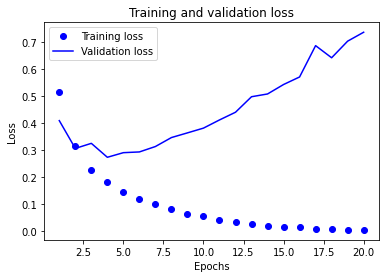

In [ ]:
# 코드 3-9 훈련과 검증 손실 그리기

import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')   # 'bo'는 파란색 점을 의미
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')  # 'b'는 파란색 실선을 의미
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

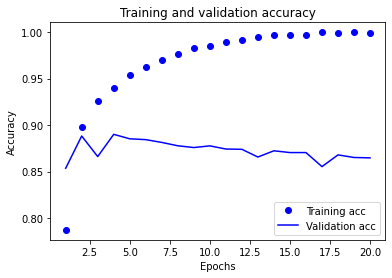

In [ ]:
# 코드 3-10 훈련과 검증 정확도 그리기

plt.clf()  # 그래프를 초기화하기
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

위에서 볼 수 있듯이 훈련 손실이 에포크마다 감소하고 훈련 정확도는 에포크마다 증가한다. 경사 하강법 최적화를 사용했을 때 반복마다 최소화되는 것이 손실이므로 기대했던 대로이다. 하지만 검증 손실과 정확도는 이와 같지 않다. 실선 그래프를 보면 그래프가 역전되는 것이 그 예이다. 이것이 훈련 세트에서 잘 작동하는 모델이 처음 보는 데이터에서 잘 작동하지 않을 수 있다고 앞서 언급한 경고의 한 사례이다.

정확히 용어로 말하면 **과대적합**(overfitting)되었다고 한다. 두 번째 에포크 이후부터 훈련 데이터에 과도하게 최적화되어 훈련 데이터에 특화된 표현을 학습하므로 훈련 세트 이외에 데이터에는 일반화하지 못한다. 

다음 코드는 처음부터 다시 새로운 신경망을 네 번의 에포크 동안만 훈련하고 평가해보겠다.

In [ ]:
# 3-11 모델을 처음부터 다시 훈련하기

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 2s 28ms/step - loss: 0.5488 - accuracy: 0.7363
Epoch 2/4
49/49 [==============================] - 1s 28ms/step - loss: 0.2728 - accuracy: 0.9097
Epoch 3/4
49/49 [==============================] - 1s 27ms/step - loss: 0.1977 - accuracy: 0.9317
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.3051 - accuracy: 0.8788


In [ ]:
results

[0.30513477325439453, 0.8788400292396545]

아주 단순한 방식으로 4번만 에포크해도 88%의 정확도를 달성했다.

모델을 훈련시킨 후에 이를 실전 환경에서 사용하고 싶을 것이다. predict 메서드를 사용해서 어떤 리뷰가 긍정일 확률을 예측할 수 있다.

In [ ]:
model.predict(x_test)

array([[0.13202694],
       [0.9988086 ],
       [0.655925  ],
       ...,
       [0.08936039],
       [0.04647765],
       [0.4794166 ]], dtype=float32)

##**Ch 3.4 정리**

*   원본 데이터를 신경망에 텐서로 주입하기 위해서는 꽤 많은 전처리가 필요하고 <br>
단어 시퀀스는 이진 벡터로 인코딩될 수 있고 다른 인코딩 방식도 있다.
*   **relu 활성화 함수**와 함께 Dense층을 쌓은 네트워크는 여러 종류의 문제에 적용 가능
*   (출력 클래스가 2개인) 이진 분류 문제에서 네트워크는 **하나의 유닛과 sigmoid 활성화 함수를 가진 Dense 층**으로 끝나야 함 <br>
이 신경망의 출력은 확률을 나타내는 0과 1 사이의 스칼라 값
*   이진 분류 문제에서 이런 스칼라 시그모이드 출력에 대해 사용할 손실 함수는 **binary_crossentropy** 이다.
*   **rmsprop** 옵티마이저는 문제와 상관없이 일반적으로 충분히 좋은 선택
*   훈련 데이터에 대해 성능이 향상됨에 따라 신경망은 **과대적합(overfitting)**되기 시작하고 이전에 본적 없는 데이터에서는 <br>
결과가 점점 나빠진다. 항상 훈련 세트 이외의 데이터에서는 성능을 모니터링   이진 분류 문제에서 이런 스칼라 시그모이드 출력에 대해 사용할 손실 함수는 **binary_crossentropy** 이다.
*   **rmsprop** 옵티마이저는 문제와 상관없이 일반적으로 충분히 좋은 선택
*   훈련 데이터에 대해 성능이 향상됨에 따라 신경망은 **과대적합(overfitting)**되기 시작하고 이전에 본적 없는 데이터에서는 <br>
   이진 분류 문제에서 이런 스칼라 시그모이드 출력에 대해 사용할 손실 함수는 **binary_crossentropy** 이다.
*   **rmsprop** 옵티마이저는 문제와 상관없이 일반적으로 충분히 좋은 선택
*   훈련 데이터에 대해 성능이 향상됨에 따라 신경망은 **과대적합(overfitting)**되기 시작하고 이전에 본적 없는 데이터에서는 <br>
결과가 점점 나빠진다. 항상 훈련 세트 이외의 데이터에서는 성능을 모니터링해야 한다.

